In [28]:
#######################################################################
# ML_in_Finance_MarketMaking
# From the Book: Machine Learning in Finance: from Theory to Practice #
# Publisher: Springer
# Code Author: Matthew Dixon: mfrdixon@gmail.com                      # 
# Date: 10/14/2019                                                    #
# About: In this example we demonstrate how to implement a market     #
# making agent and train it to capture the spread from a limit order  #
# book price signal.                                                  #
#                                                                     #
#######################################################################

We can build on the previous two examples by considering the problem of high frequency market making. Unlike the previous example, we shall learn a time independent optimal policy.

Assume that a market maker seeks to capture the bid-ask spread by placing one lot best bid and ask limit orders. They are required to strictly keep their inventory between -1 and 1. The problem is when to optimally quote either a bid or ask, or simply wait, each time there is a limit order book update. For example, sometimes it may be more advantageous to quote a bid to close out a short position if it will almost surely give an instantaneous net reward, other times it may be better to wait and capture a larger spread.

In this toy example, the agent uses the liquidity imbalance in the top of the order book as a proxy for price movement and, hence, fill probabilities. The example does not use market orders, knowledge of queue positions, cancellations and limit order placement at different levels of the ladder. These are left to later material and exercises.

At each non-uniform time update, $t$, the market feed provides best prices and depths $\{p^a_t, p^b_t, q^a_t, q^b_t\}$. The state space is the product of the inventory, $X_t\in\{-1,0,1\}$, and gridded liquidity ratio $\hat{R}_t= \lfloor{\frac{q^a_t}{q^a_t+q^b_t}N\rfloor}\in [0,1]$, where $N$ is the number of grid points and $q^a_t$ and $q^b_t$ are the depths of the best ask and bid. $\hat{R}_t \rightarrow 0$ is the regime where the mid-price will go up and an ask is filled. Vice versa for $\hat{R}_t \rightarrow 1$. The dimension of the state space is chosen to be $ 3 \cdot 5 = 15$.

A bid is filled with probability $\epsilon_t:=\hat{R}_t$ and an ask is filled with probability $1-\epsilon_t$. The rewards are chosen to be the expected total P\&L. If a bid is filled to close out a short holding, then the expected reward $r_t=-\epsilon_t (\Delta p_t+c)$, where $\Delta p_t$ is the difference between the exit and entry price and $c$ is the transaction cost. For example, if the agent entered a short position at time $s<t$ with a filled ask at $p^a_s=100$ and closed out the position with a filled bid at $p^b_t=99$, then $\Delta p_t=1$. The agent is penalized for quoting an ask or bid when the position is already short or long respectively.

We can now apply SARSA or Q-learning to learn optimal market making in such a simplified setting. For exploration needed for on-line learning, one can use a
$\varepsilon $-greedy policy.

### Import some libraries

In [30]:
import random
import sys
sys.path.append('.\dqMM')
import numpy as np
import matplotlib.pyplot as plt
from tgym.gens.csvstream import CSVStreamer
from tqdm import tqdm 
#To ignore warnings that are annoying.
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up

### Set up some global parameters

In [31]:
# Probability for exploration - epsilon
EPSILON = 0.5 
# Step size
ALPHA = 0.05
# Gamma for Q-Learning and Sarsa
GAMMA = 1

In [32]:
ACTIONS = [0,1,2] # possible actions
NUM_INV_STEPS = 3 #number of inventories: long, short, flat
NUM_PROB_STEPS = 10 #numeber of probabilities
FILL_PROBS = np.arange(0,1,1.0/NUM_PROB_STEPS) #the probabilities are discretised
c = 0 # transaction cost
MAX_ITER = 50000 #Number of iterations in one episode

#### The data generator
- The data generator takes and returns the Limit Order Book update from CSV file

In [33]:
data_generator= CSVStreamer(filename='dqMM/data/AMZN-L1.csv')

#### State
- The state is: [position (flat, long, short); probability of ask fill (index in the array of probabilities); prices (a dictionary of bid and ask); entry price]
- We note however the q-value function is dependent only on position, ask fill probability and action. The prices are considered by the agent for learning even though they are part of the state 

In [34]:
# Initial state
price= {'bid':2237.5, 'ask':2239.5}
START = [0,3, price, 0] #position, q - index in array of probabilities, prices, entry price
actions = {'buy':2, 'sell':0, 'hold': 1}
positions ={'flat': 0, 'long': 2, 'short':1}
global entry_price

#### Setting up the environment

In [35]:
def step(state, action):
        """Take an action (buy/sell/hold) and computes the immediate reward.

        Args:
            action (numpy.array): Action to be taken.

        Returns:
            tuple:
                - observation (numpy.array): Agent's observation of the current environment.
                - reward (float) : Amount of reward returned after previous action.
 
        """
        #assert (actions.has_key(action)) and (positions.has_key(position))
        info ={}  
        position, q, price, entry_price = state
        reward = 0 
        instant_pnl = 0 
        r = np.random.rand()
        done = False
        
        # The fill ask and bid probabilities are sum up to 1 always, meaning that always the one of bid or ask orders 
        #is being executed 
        fill_bid = False
        fill_ask = True
        if (r>=FILL_PROBS[q]):
            fill_bid = True
            fill_ask = False
        
        
        if (action == actions['buy']) and (fill_bid):
            reward = -c
            if (position == positions['flat']):         
                position = positions['long']
                entry_price =  price['bid']  # bid
                #reward -= 0 #self._entry_price
            elif(position == positions['short']): # closed out a short position          
                position = positions['flat']
                exit_price =  price['bid']  # bid prices_history[-1][0]

                instant_pnl = entry_price - exit_price
                entry_price = 0

        elif (action == actions['sell']) and (fill_ask):
            reward = -c
            if (position == positions['flat']):
                position = positions['short']
                entry_price = price['ask']  # ask
            elif (position == positions['long']):
                exit_price = price['ask']  # ask
                instant_pnl = exit_price - entry_price
                position = positions['flat']
                entry_price = 0

                
        reward += instant_pnl
      
        # Run out of data?
        try:
            qq =0
            gen = np.array(data_generator.next())
            
            price = {'bid': gen[2]/1000.0, 'ask': gen[0]/1000.0}    
            depth = {'bid': gen[3], 'ask': gen[1]}
        
            q = np.float(depth['bid'])/(depth['bid']+depth['ask'])
            # quantize q
            qq= np.int(np.floor(q*NUM_PROB_STEPS)) ##qq is an index in the vector of the fill probabilities
            ##this is done to descretise the continious variable - probability
       
            
        except StopIteration:
            done = True
            info['status'] = 'No more data.'
        #if iteration >= episode_length:
        #    done = True
        #    info['status'] = 'Time out.'
        
        next_state= position, qq, price, entry_price
        #observation = self._get_observation()
        return next_state, reward, done

In [36]:
# Check START state, action pairs and the associated reward
print(step(START, 0))
print(step(START, 1))

((0, 5, {'bid': 2231.8, 'ask': 2239.5}, 0), 0, False)
((0, 1, {'bid': 2238.1, 'ask': 2239.5}, 0), 0, False)


#### Set up the agent's action

In [37]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    
    position, q, price, entry_price = state
    if np.random.binomial(1, eps) == 1: #with probability eps we randonly chose among allowed actions
        
        if position==positions['long']:
              action = np.random.choice([actions['hold'], actions['sell']])
        elif position==positions['short']:
              action = np.random.choice([actions['hold'], actions['buy']])
        else:
              action = np.random.choice([actions['hold'], actions['buy'], actions['sell']])  
    else:
        
        if position==positions['long']:
            actions_=[actions['hold'], actions['sell']]        
        elif position==positions['short']:
            actions_=[actions['hold'], actions['buy']]
        else:
            actions_=[actions['hold'], actions['buy'], actions['sell']]
        
        values_ = q_value[state[0], state[1], actions_]
        
        action = np.random.choice([actions_[action_] for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    return action

In [38]:
q_value = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS))) 
#q-value funciton is a cube consisting of three dimensions: position, probability and action
#even though the price is part of the state q-value function does not take it into account
state = [0,4, price, 0]
choose_action(state, q_value, EPSILON)

0

#### Set up the learning algorithms

##### Sarsa and Expected Sarsa

In [39]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value, eps)
    rewards = 0.0
    done  = False
    iteration = 0

#     print('In sarsa: action = ', action)
    while (iteration < MAX_ITER) and not done:
        next_state, reward, done = step(state, action)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS: 
                if action_ in best_actions:
                    target += ((1.0 -  eps) / len(best_actions) 
                               +  eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target +=  eps / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        iteration += 1
        
    return rewards

##### Q-learning

In [40]:
# An episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA, eps=EPSILON):
    state = START
    rewards = 0.0
    done  = False
    iteration = 0
    
    while (iteration < MAX_ITER) and not done:
        action = choose_action(state, q_value, eps)
        next_state, reward, done = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
        iteration +=1
    return rewards

##### Printing output of the learned policy

In [41]:
# Print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS))
    for i in range(0, NUM_INV_STEPS):
        for j in range(0, NUM_PROB_STEPS):
                optimal_policy[i,j] = np.argmax(q_value[i, j, :])
            
    print("ask fill prob:", FILL_PROBS)
    for i in range(0, NUM_INV_STEPS):
        
        #positions ={'flat': 0, 'long': 2, 'short':1}
        str_=""
        if (i==0):
            str_+= 'flat: '
        elif(i==1):
            str_+= 'short: '
        else:
            str_+= 'long: '
            
        for j in range(0, NUM_PROB_STEPS): 
            a = np.int(optimal_policy[i,j])
            #actions = {'buy':2, 'sell':0, 'hold': 1}
            if a == 0:
                str_+='s' + ','
            elif a ==1:
                str_+='h' + ',' 
            else:
                str_+='b' + ','  
        print(str_)  

#### Set up the epsilon decay
- We will use the decreasing epsison when increasing episode
- The epsilon should strives to zero in order for the q-value function to converge to the optimal q-value function in SARSA algorithm
- The following figure demonstrates the exponetial decay we are going to use

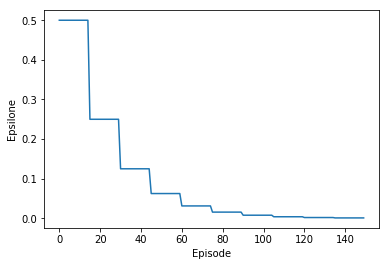

In [42]:
eps = 0.5
epis = 150
epoch = 15

plt.plot([eps*((1-eps)**(i//epoch)) for i in range(epis)])
plt.xlabel('Episode')
plt.ylabel('Epsilone')

### Running Sarsa and Q-learning 

In [43]:
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure_6_4(policy):
    # episodes of each run
    episodes = 150
    EPOCH = 15

    # perform 100 independent runs
    runs = 1

    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
        q_sarsa = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)))
        q_q_learning = np.copy(q_sarsa)
        data_generator.rewind()
        for i in range(0, episodes):
            # cut off the value by -100 to draw the figure more elegantly
            # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
            # rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
            #
            eps = EPSILON*((1-EPSILON)**(i//EPOCH))
            if policy=='sarsa':
                rewards_sarsa[i] += sarsa(q_sarsa, eps=eps)
            #data_generator.rewind()
            else:
                rewards_q_learning[i] += q_learning(q_q_learning, eps=eps)

    # averaging over independt runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # draw reward curves
    if policy=='sarsa':
        plt.plot(rewards_sarsa, label='Sarsa')
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        #plt.ylim([-100, 0])
        plt.legend()
        #plt.savefig('figure_6_4.png')
        #plt.close()

        print('Sarsa Optimal Policy:')
        print_optimal_policy(q_sarsa)
        return q_sarsa
        
    else:
        plt.plot(rewards_q_learning, label='Q-Learning')
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        #plt.ylim([-100, 0])
        plt.legend()
        #plt.savefig('figure_6_4.png')
        #plt.close()

        print('Q-Learning Optimal Policy:')
        print_optimal_policy(q_q_learning)
        return q_q_learning

    
# display optimal policy    


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:15<00:00, 315.34s/it]

Sarsa Optimal Policy:
ask fill prob: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
flat: b,b,b,b,b,b,b,s,s,s,
short: b,b,b,b,b,b,b,b,b,b,
long: s,h,h,h,s,s,s,s,s,s,



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:58<00:00, 358.09s/it]

Q-Learning Optimal Policy:
ask fill prob: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
flat: b,b,b,b,b,b,s,s,s,s,
short: b,b,b,b,b,b,b,b,b,b,
long: s,s,s,s,s,s,s,s,s,s,


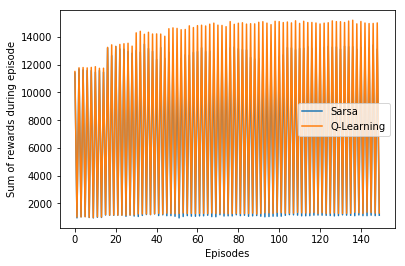

In [44]:
q_sarsa= figure_6_4('sarsa')
q_q_learning = figure_6_4('q-learning')

### Running Sarsa, Expected Sarsa and Q-learning to compare their asymptotic behavior

In [23]:
# Due to limited capacity of calculation of my machine, I can't complete this experiment
# with 100,000 episodes and 50,000 runs to get the fully averaged performance
# However even I only play for 500 episodes and 1000 steps per episode, the curves looks still good.
# MFD: not finished yet.
def figure_6_6():
    step_sizes = np.arange(0.01, 0.2, 0.04)
    episodes = 500
    runs = 1

    ASY_SARSA = 0
    ASY_EXPECTED_SARSA = 1
    ASY_QLEARNING = 2
    INT_SARSA = 3
    INT_EXPECTED_SARSA = 4
    INT_QLEARNING = 5
    methods = range(0, 6)

    performace = np.zeros((6, len(step_sizes)))
    for run in range(runs):
        for ind, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):
            q_sarsa = np.zeros((NUM_INV_STEPS, NUM_PROB_STEPS, len(ACTIONS)))
            q_expected_sarsa = np.copy(q_sarsa)
            q_q_learning = np.copy(q_sarsa)
            for ep in range(episodes):
                sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size, eps=0.1)
                expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size, eps=0.1)
                q_learning_reward = q_learning(q_q_learning, step_size=step_size, eps=0.1)
                performace[ASY_SARSA, ind] += sarsa_reward
                performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[ASY_QLEARNING, ind] += q_learning_reward

                if ep < 100:
                    performace[INT_SARSA, ind] += sarsa_reward
                    performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                    performace[INT_QLEARNING, ind] += q_learning_reward

    performace[:3, :] /= episodes * runs
    performace[3:, :] /= 100 * runs
    labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
              'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']

    for method, label in zip(methods, labels):
        plt.plot(step_sizes, performace[method, :], label=label)
    plt.xlabel('alpha')
    plt.ylabel('reward per episode')
    plt.legend()

#     plt.savefig('../images/figure_6_6.png')
#     plt.close()

# if __name__ == '__main__':


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d


 20%|███████████████▌                                                              | 1/5 [1:14:16<4:57:06, 4456.72s/it]

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d


 40%|███████████████████████████████▏                                              | 2/5 [2:27:19<3:41:43, 4434.46s/it]

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d


 60%|██████████████████████████████████████████████▊                               | 3/5 [5:14:53<3:24:01, 6120.52s/it]

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d


 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [7:06:27<1:44:52, 6292.36s/it]

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d

End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of data reached, rewinding.
End of d


100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [11:46:18<00:00, 9442.06s/it]

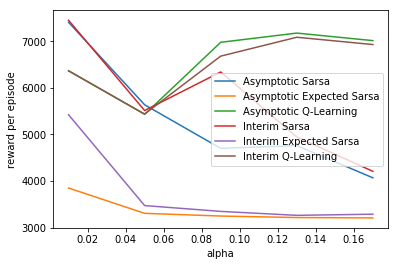

In [24]:
figure_6_6()

### Run animation of the market-making according to the learned policies for one episode

<IPython.core.display.Javascript object>


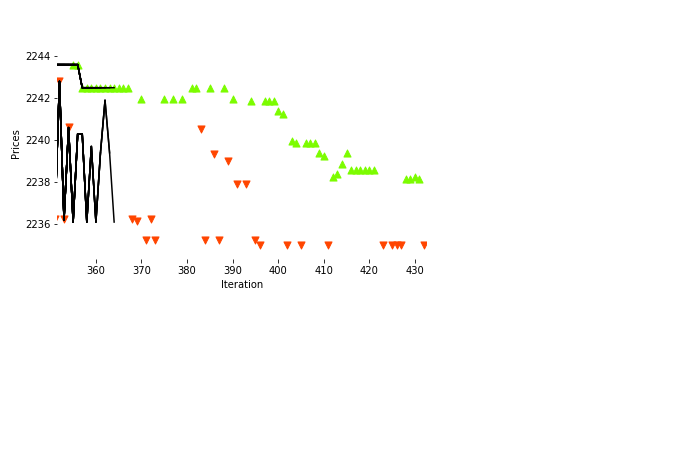

KeyboardInterrupt: 

In [27]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.gridspec import GridSpec
#plt.rcdefaults()


fig=plt.figure(figsize=(12, 8))

gs=GridSpec(2,2) # 2 rows, 2 columns

ax1=fig.add_subplot(gs[0,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column
ax3=fig.add_subplot(gs[1,0]) # First row, third column

t=20
bids=[]
asks=[]
bid_fills = []
xdata=[]
pnl = []

objects = ['bid','ask']
y_pos = range(len(objects))


done = False
state = START
rewards = 0.0
done  = False
iteration = 0

#Run one episode for SARSA
    
while (iteration < MAX_ITER) and not done:
    
    
    action = np.argmax(q_sarsa[state[0], state[1], :]) #this is SARSA, change to q_learning to check out Q-learning algorithm
    
    state, reward, done = step(state, action)
    iteration += 1
    
    position_name = [name for name, pos in positions.items() if pos == state[0]][0] 
    action_name = [name for name, act in actions.items() if act == action][0]                    
    prices = state[2]
    
    #Cumulative PnL
    if len(pnl)==0:
        pnl.append(reward)
    else: 
        pnl.append(pnl[-1]+reward)
        
    #Prices
    bids.append(prices['bid'])
    asks.append(prices['ask'])
    xdata.append(iteration)
    
    ax1.plot(xdata, bids, color = 'black')
    ax1.plot(xdata, asks, color = 'black')
    ax1.set_ylabel('Prices')
    ax1.set_xlabel('Iteration')
    ax1.set_title('Cumulated PnL: ' + "%.2f" % pnl[-1] + ' ~ ' +
                 'Position: ' + position_name + ' ~ ' +
                 'Entry Price: ' + "%.2f" % state[-1])
    ax1.set_xlim([max(0, iteration - 80.5), iteration + 0.5])
    
    #Plotting actions acrrording to the Policy
    if (action == actions['sell']):
        
        ax1.scatter(iteration, prices['bid']+0.03, color='orangered', marker='v',  s=50)
    elif (action == actions['buy']).all():
        ax1.scatter(iteration, prices['ask']-0.03, color='lawngreen', marker='^', s=50)
    
    #Ploting PnL
    ax2.clear()
    ax2.plot(xdata, pnl)
    ax2.set_ylabel('Total PnL')
    ax2.set_xlabel('Iteration')
    
    #Plotting current probabilities to fill
    q_a = FILL_PROBS[state[1]]
    q_b = 1-q_a
    performance = [q_b, q_a]
    
    ax3.clear()
    ax3.bar(y_pos, performance, align='center', alpha=0.5, color=['orangered','lawngreen'])
    ax3.set_xticks(y_pos)
    ax3.set_xticklabels(objects)
    ax3.set_title('Probability of fill')
    ax3.set_ylim([0,1])
    
    fig.tight_layout()
    fig.canvas.draw()
    time.sleep(0.5)

### Additional exercises:
- Problem description: 
    - Assume now that the market-making bot is able to make 'market' orders. In our settings the market order means buy/sell immediately at the available price to close the short/long position correspondingly. For example, if the position is short, we can immediately make buy market order to close the position at the available price (best ask price). Assume for now that there is infinite amount of liquidity in the market (we can always make the trade with any amount at the corresponding price levels).
- Task: 
    - Adjust the code such that agent has additional action (market order). In this case if the position is long that there is only possibility for sell market order. In case the position is short we can only make buy market order.
    - Run the results for different tickets (AAPL-L1, GOOG-L1, INTC-L1, MSFT-L1) and calculate total cumulative PnL for each
